In [284]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [285]:
class ACO(object):
    def __init__(self, num_city, data):
        self.m = 30
        self.alpha = 1
        self.beta = 5
        self.rho = 0.1
        self.Q = 100
        self.num_city = num_city
        self.location = data
        self.Tau = np.full((num_city, num_city), 1.5) # 信息素矩阵
        self.Table = [[0 for _ in range(num_city)] for _ in range(self.m)] # 生成的蚁群
        self.iter = 1
        self.iter_max = 200
        self.dis_mat = self.compute_dis_mat(num_city, self.location)
        self.Eta = 10. / self.dis_mat
        self.paths = None
        self.iter_x = []
        self.iter_y = []

        # Optimize
        self.relation = [[[0 for _ in range(num_city)] for _ in range(num_city)] for _ in range(num_city)]

    def get_dist(self, x, y, z):
        tmp = np.sqrt((y[0] - z[0]) ** 2 + (y[1] - z[1]) ** 2)
        return tmp

    def sigmod(self, x):
        return 1 / (1 + np.exp(-x))

    def get_realation(self, num_city):
        for i in range(num_city):
            for j in range(num_city):
                if i == j: continue
                cor_dis = []
                mean = 0
                maxval = 0
                for k in range(num_city):
                    if i == k or j == k: continue
                    result = self.get_dist(self.location[i], self.location[j], self.location[k])
                    cor_dis.append(result)
                    mean += result
                    if result > maxval: maxval = result

                tot = 0
                for k in range(num_city):
                    if i == k or j == k: continue
                    self.relation[i][j][k] = self.sigmod((cor_dis[tot] - mean) / maxval / 20)
                    tot += 1
                    # print(self.relation[i][j][k])
                    

    def rand_choose(self, p):
        x = np.random.rand()
        for i, t in enumerate(p):
            x -= t
            if x <= 0:
                break
        return i

    def get_ants(self, num_city):
        for i in range(self.m):
            start = np.random.randint(num_city - 1)
            self.Table[i][0] = start
            unvisit = list([x for x in range(num_city) if x != start])
            current = start
            j = 1
            while len(unvisit) != 0:
                P = []
                for v in unvisit:
                    P.append(self.Tau[current][v] ** self.alpha * self.Eta[current][v] ** self.beta)
                P_sum = sum(P)
                P = [x / P_sum for x in P]
                index = self.rand_choose(P)
                current = unvisit[index]
                self.Table[i][j] = current
                unvisit.remove(current)
                j += 1

    def compute_dis_mat(self, num_city, location):
        dis_mat = np.zeros((num_city, num_city))
        for i in range(num_city):
            for j in range(num_city):
                if i == j:
                    dis_mat[i][j] = np.inf
                    continue
                a = location[i]
                b = location[j]
                tmp = np.sqrt(sum([(x[0] - x[1]) ** 2 for x in zip(a, b)]))
                dis_mat[i][j] = tmp
        return dis_mat
    
    def compute_pathlen(self, path, dis_mat):
        a = path[0]
        b = path[-1]
        result = dis_mat[a][b]
        n = len(path)
        for i in range(n - 1):
            a = path[i]
            b = path[i + 1]
            result += dis_mat[a][b]
        return result
    
    def compute_paths(self, paths):
        result = []
        for pth in paths:
            length = self.compute_pathlen(pth, self.dis_mat)
            result.append(length)
        return result
    
    def update_Tau(self):
        delta_tau = np.zeros([self.num_city, self.num_city])
        paths = self.compute_paths(self.Table)
        for i in range(self.m):
            for j in range(self.num_city - 1):
                a = self.Table[i][j]
                b = self.Table[i][j + 1]
                delta_tau[a][b] += self.Q / paths[i]

            a = self.Table[i][0]
            b = self.Table[i][-1]
            delta_tau[a][b] += self.Q / paths[i]

        self.Tau = (1 - self.rho) * self.Tau + delta_tau

    def diffusion_Tau(self, num_city):
        for i in range(num_city):
            for j in range(i + 1, num_city):
                for k in range(i + 1, num_city):
                    if j == k: continue
                    self.Tau[i][k] += self.Tau[i][j] * self.relation[i][j][k] * (self.iter / self.iter_max)

    def aco(self):
        self.get_realation(self.num_city)
        best_length = np.inf
        best_path = None
        self.iter = 1
        for cnt in range(self.iter_max):
            self.get_ants(self.num_city)
            self.paths = self.compute_paths(self.Table)

            tmp_lenth = min(self.paths)
            tmp_path = self.Table[self.paths.index(tmp_lenth)]

            if cnt == 0:
                init_show = self.location[tmp_path]
                init_show = np.vstack([init_show, init_show[0]])
            
            if tmp_lenth < best_length:
                best_length = tmp_lenth
                best_path = tmp_path

            self.diffusion_Tau(self.num_city)
            self.update_Tau()

            self.iter_x.append(cnt)
            self.iter_y.append(best_length)

            # if cnt % 50 == 0:
            #     print('Epoches: ', self.iter, 'Get best length: ', best_length)
            # self.iter += 1

        return best_length, best_path
    
    def run(self):
        best_length, best_path = self.aco()
        return self.location[best_path], best_length

In [286]:
def read_tsp(path):
    lines = open(path, 'r').readlines()
    assert 'NODE_COORD_SECTION\n' in lines
    index = lines.index('NODE_COORD_SECTION\n')
    data = lines[index + 1:-1]
    tmp = []
    for line in data:
        line = line.strip().split(' ')
        if line[0] == 'EOF':
            continue
        tmpline = []
        for x in line:
            if x == '':
                continue
            else:
                tmpline.append(float(x))
        if tmpline == []:
            continue
        tmp.append(tmpline)
    data = tmp
    return data

Epoches  0 :  725.1219462165298
Epoches  1 :  734.6698369772386
Epoches  2 :  727.7671750421151
Epoches  3 :  760.9143065426392
Epoches  4 :  716.6807889287719
Ave=  733.0308107414589
Maxdis=  760.9143065426392
Mindis=  716.6807889287719


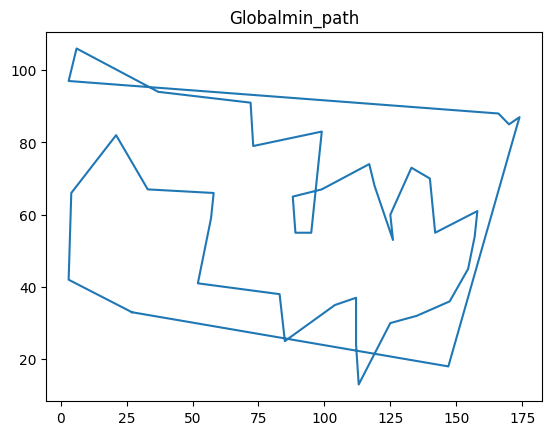

In [287]:
data = read_tsp('dantzig42.tsp')

data = np.array(data)
data = data[:, 1:]

res = 0
mindis = np.inf
maxdis = 0
Globalmin_path = []

for i in range(5):
    aco = ACO(num_city=data.shape[0], data=data.copy())
    Best_path, Best = aco.run()
    if Best < mindis: 
        mindis = Best
        Globalmin_path = Best_path
    if Best > maxdis: maxdis = Best
    res += Best
    print('Epoches ', i, ': ', Best)

print('Ave= ', res / 5)
print('Maxdis= ', maxdis)
print('Mindis= ', mindis)

Globalmin_path = np.vstack([Globalmin_path, Globalmin_path[0]])
plt.plot(Globalmin_path[:, 0], Globalmin_path[:, 1])
plt.title('Globalmin_path')
plt.show()